# Project Description

This is a practice project where I will try to learn some information filtering techniques. In this project, I will attempt at implementing various recommendation algorithms (popularity based, content based, and collaborative filtering) and try to build an ensemble of these models to come up with the final recommendation system. The data source I use provided two sets of data:

* The Full Dataset: Consists of 26,000,000 ratings and 750,000 tag applications applied to 45,000 movies by 270,000 users. Includes tag genome data with 12 million relevance scores across 1,100 tags.
* The Small Dataset: Comprises of 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users.

I will be using the small dataset due to limiting computing power available to me. Also I will be loading data as needed, as different methods will be utilizing different data fields from different files.

# Project Pipeline

1. IMDb score method: This method offers generalized recommendations to every user, based on movie popularity.
2. Correlation matrix method: This method also offers generalized recommendations, but based on correlation matrix of user ratings.
3. Content based filtering method: This method suggests similar items based on a particular item.
4. Collaborative filtering method: This method is based on assumption that people like things similar to other things they like, and things that are liked by other people with similar taste.
5. Hybrid recommender: This approach is to combine collaborative filtering and content-based filtering
6. Summarize

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

# Part I: IMDb Score Method

This method offers generalized recommendations to every user, based on movie popularity and/or genre. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience. We just need a metric to score or rate every movie. In this case I will use the formula provided by MDB: [How do you calculate the rank of movies and TV shows on the Top Rated Movies and Top Rated TV Show lists?](https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#calculatetop)

In [2]:
movie_info = pd.read_csv('../input/the-movies-dataset/movies_metadata.csv')

# get rid of abnormal 'id' values in movie_info and convert 'id' to 'int' type
movie_info = movie_info.drop([19730, 29503, 35587])
movie_info['id'] = movie_info['id'].astype('int')
movie_info['popularity'] = movie_info['popularity'].astype('float')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


From IMBd website I learned the formula to score a movie is: 

**weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C**

Where:
* R = average for the movie (mean) = (rating)
* v = number of votes for the movie = (votes)
* m = minimum votes required to be listed in the Top Rated list
* C = the mean vote across the whole report

In [3]:
# the mean rating for all the movies
C = movie_info['vote_average'].mean() 
# the minimum votes required to be listed in the chart
m = movie_info['vote_count'].quantile(0.9) 

In [4]:
# calculate score metric for each qualified movie
def weighted_rating(x,m=m,C=C): 
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(v+m) * C)

In [5]:
# filter out the movies that qualify for the chart
quality_movies = movie_info.copy().loc[movie_info['vote_count']>=m] 
# calculate the movie score using above formula and add it as a new column to the data frame
quality_movies['score'] = quality_movies.apply(weighted_rating,axis=1)
#Sort movies based on score calculated above
quality_movies = quality_movies.sort_values('score',ascending=False) 

In [6]:
top_15_quality_movie = quality_movies[['title','vote_count','vote_average','score']].head(15) 
top_15_quality_movie

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.445869
834,The Godfather,6024.0,8.5,8.425439
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421453
12481,The Dark Knight,12269.0,8.3,8.265477
2843,Fight Club,9678.0,8.3,8.256385
292,Pulp Fiction,8670.0,8.3,8.251406
522,Schindler's List,4436.0,8.3,8.206639
23673,Whiplash,4376.0,8.3,8.205404
5481,Spirited Away,3968.0,8.3,8.196055
2211,Life Is Beautiful,3643.0,8.3,8.187171


Alternatively we can just utilize the column 'Popularity' provided in the dataset and draw the top 15 popular movies. Although 'Popularity' might just reflect movies that are currently trending and popular. A most recommended movie from the past might not show up as a currently popular movie.

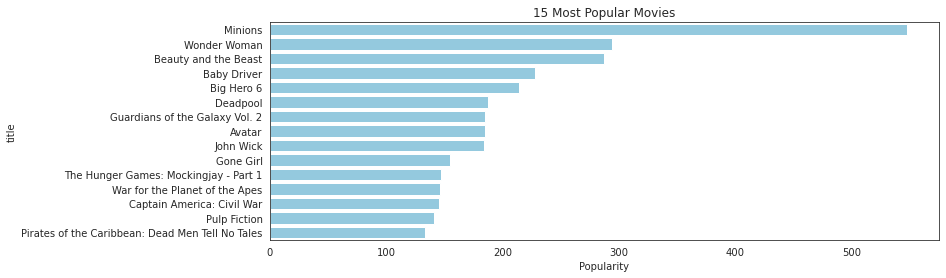

In [7]:
top_15_popular_movie = movie_info.sort_values('popularity',ascending=False)[['title','vote_count','vote_average','popularity']].head(15)

plt.figure(figsize=(12,4))
sns.barplot(y=top_15_popular_movie['title'],x=top_15_popular_movie['popularity'],color='skyblue')
#plt.gca().invert_yaxis()
plt.xlabel('Popularity')
plt.title('15 Most Popular Movies')
plt.show()

# Part II: Correlation Matrix Method

Popularity method works by recommeding movies watched and reviewed by most people and are rated high. It is not a personalized recommendation. In this case, I will alculate popularity of movies as how each of other movies is correlated to a certain movie based on each individual user's rating among all movies. 

In [8]:
ratings = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')
id_links = pd.read_csv('../input/the-movies-dataset/links_small.csv')[['movieId','tmdbId']]

id_links = id_links[id_links['tmdbId'].notnull()]
id_links['tmdbId'] = id_links['tmdbId'].astype('int')

In [9]:
df = ratings.merge(id_links,on='movieId')
df.columns = ['userId','movieId','rating','timestamp','id']

In [10]:
movie_info = movie_info[movie_info['id'].isin(df['id'])]
df = df.merge(movie_info[['title','id']],on='id')

In [11]:
print('Movies with highest average ratings:\n',df.groupby('title')['rating'].mean().sort_values(ascending=False))
print('\n\nMovies with the most ratings counts:\n',df.groupby('title')['rating'].count().sort_values(ascending=False))

Movies with highest average ratings:
 title
The Last Brickmaker in America    5.0
Neighboring Sounds                5.0
Kids in America                   5.0
I Think I Do                      5.0
Miracle Mile                      5.0
                                 ... 
Ring of Terror                    0.5
Left Behind III: World at War     0.5
Hells Angels on Wheels            0.5
Roadgames                         0.5
The Grudge 2                      0.5
Name: rating, Length: 8754, dtype: float64


Movies with the most ratings counts:
 title
Forrest Gump                             341
Pulp Fiction                             324
The Shawshank Redemption                 311
The Silence of the Lambs                 304
Star Wars                                291
                                        ... 
Sex Ed                                     1
Sex and the City 2                         1
Fashion Victims                            1
Sgt. Pepper's Lonely Hearts Club Band      1

From the above, you can see some movies with highest ratings end up with only one rating count. I will put these two indicators together and do a joint analysis.

In [12]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
print(ratings.sort_values('num of ratings',ascending=False).head(10))

                              rating  num of ratings
title                                               
Forrest Gump                4.054252             341
Pulp Fiction                4.256173             324
The Shawshank Redemption    4.487138             311
The Silence of the Lambs    4.138158             304
Star Wars                   4.221649             291
Jurassic Park               3.706204             274
The Matrix                  4.183398             259
Toy Story                   3.872470             247
Schindler's List            4.303279             244
Terminator 2: Judgment Day  4.006329             237


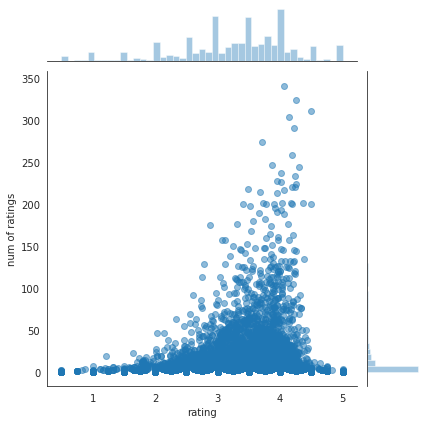

In [13]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)
plt.show()

In [14]:
moviemat = df.pivot_table(index='userId',columns='title',values='rating')
moviemat.head()

title,$9.99,'Neath the Arizona Skies,"'night, Mother",(500) Days of Summer,...And God Created Woman,...And Justice for All,1-900,10,10 Attitudes,10 Cloverfield Lane,...,eXistenZ,loudQUIETloud: A Film About the Pixies,xXx,xXx: State of the Union,¡Three Amigos!,À Nous la Liberté,Æon Flux,İtirazım Var,Želary,’Round Midnight
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
avatar_user_ratings = moviemat['Avatar']
#starwars_user_ratings = moviemat['Star Wars']
#terminator2_user_ratings = moviemat['Terminator 2: Judgment Day']

In [16]:
# calculate how each of other movies is correlated to a certain movie based on each individual user's rating among all movies
similar_to_avatar = moviemat.corrwith(avatar_user_ratings)
#similar_to_starwars = moviemat.corrwith(starwars_user_ratings) 
#similar_to_terminator2 = moviemat.corrwith(terminator2_user_ratings)

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [17]:
corr_avatar = pd.DataFrame(similar_to_avatar,columns=['Correlation'])
corr_avatar.dropna(inplace=True)
corr_avatar.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Fantastic Planet,1.0
Blood Simple,1.0
Everything You Always Wanted to Know About Sex *But Were Afraid to Ask,1.0
The Place Beyond the Pines,1.0
Abbott and Costello Meet Frankenstein,1.0
Dreamgirls,1.0
Middle Men,1.0
Kazaam,1.0
Blended,1.0


From the above result, you can see some movies are recognized as perfectly correlated with The Dark Knight, although common sense tell us that it's because these moves are rarely watched and correlation could be accidental, so we need to filter out these "correlated" movies based on 'num of ratings'.

In [18]:
# filter out any movies with less than 100 ratings
corr_avatar = corr_avatar.join(ratings['num of ratings']) # here I use .join() instead of .merge() because both corr_avatar and ratings tables have the same index 'title'
corr_avatar[corr_avatar['num of ratings']>100].sort_values('Correlation',ascending=False).head(10)

,Correlation,num of ratings
title,,
Star Trek: Generations,0.788383,114
Independence Day,0.728728,218
Mission: Impossible,0.724207,168
Speed,0.699403,180
Schindler's List,0.664693,244
The Firm,0.638222,110
The Bourne Identity,0.634698,113
Return of the Jedi,0.602493,217
The Lord of the Rings: The Two Towers,0.596398,188


This time the recommend results look more reasonable. Fun fact: sometimes recommendation system recommends a movie might not be how similar the movies' features are, but simply both movies are popular, in other words, movie is recommended based on similar popularity.

# Part III: Content Based Filtering Method

This method suggests similar items based on a particular item. It is based on item content information, such as genre, director, description, actors, etc. for movies, to make these recommendations, instead of based on user opinions. The main idea behind is that if a person liked a particular item, he or she will also like other similar item.

Back to this task, for starters, the most straightforward factor to decide whether two movies are similar content-wise is probably "overview", as it summarizes the movie story. However, one thing I noticed from my HBO experience is that, after I watched "The Dark Knight", HBO started recommending the Batman-universe movies such as "Batman v Superman" or "Batman & Robin" or "Batman Returns". Though in real life what I'm more likely interested in are probably "The Prestige" or "Inception", i.e. Christopher Nolan directed movies or movies that cast Christian Bale. I know HBO couldn't recommend these movies because they don't have it now, but you get the idea: Apparently director or cast should be more prevailing factor than movie overview.

So I will dig into a recommender system that is based on Cast, Crew, Keywords and Genre, et cetera.


In [19]:
credits = pd.read_csv('../input/the-movies-dataset/credits.csv')
keywords = pd.read_csv('../input/the-movies-dataset/keywords.csv')

keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')

In [20]:
movie_info = movie_info.merge(credits, on='id')
movie_info = movie_info.merge(keywords, on='id')

In [21]:
# take look at how the values are stored in these "stringified" fields
movie_info['cast'][0:1].values

array(["[{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Wallace Shawn', 'order': 4, 'profile_path': '/oGE6Jq

In [22]:
# Parse the features into a usable structure
from ast import literal_eval 
features = ['cast','crew','keywords','genres']
for feature in features:
    movie_info[feature] = movie_info[feature].apply(literal_eval)

* Crew: From the crew, I will only pick the director as feature since the others don't contribute that much to the feel of the movie.
* Cast: As lesser known actors and minor roles do not really affect people's opinion of a movie, I will only select the major characters and their respective actors. I will assume the top 3 actors that appear in the credits list are the major actors.

In [23]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x): 
    for i in x:
        if i['job']=='Director':
            return i['name']
    return np.nan

movie_info['director'] = movie_info['crew'].apply(get_director)

In [24]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x): 
    if isinstance(x,list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3: 
            names = names[:3]
        return names
    #Return empty list in case of missing/malformed data
    return [] 

features = ['cast','keywords','genres']
for feature in features:
    movie_info[feature] = movie_info[feature].apply(get_list)

The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that the vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.

In [25]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x): 
    if isinstance(x,list):
        return [str.lower(i.replace(' ','')) for i in x]
    #Check if director exists. If not, return empty string
    else: 
        if isinstance(x,str):
            return str.lower(x.replace(' ',''))
        else:
            return ''
features = ['cast', 'director', 'keywords', 'genres']
for feature in features:
    movie_info[feature] = movie_info[feature].apply(clean_data)

One additional step before creating the "meta" string: I'd like to assign more weight to the field "director" relative to the entire cast, i.e. mention the director field twice

In [26]:
movie_info['director'] = movie_info['director'].apply(lambda x: [x,x])

In [27]:
# take a look at the transformed fields
movie_info[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Toy Story,"[tomhanks, timallen, donrickles]","[johnlasseter, johnlasseter]","[jealousy, toy, boy]","[animation, comedy, family]"
1,Jumanji,"[robinwilliams, jonathanhyde, kirstendunst]","[joejohnston, joejohnston]","[boardgame, disappearance, basedonchildren'sbook]","[adventure, fantasy, family]"
2,Grumpier Old Men,"[waltermatthau, jacklemmon, ann-margret]","[howarddeutch, howarddeutch]","[fishing, bestfriend, duringcreditsstinger]","[romance, comedy]"


In [28]:
# Now to create the "metadata soup", which is a string that contains all the metadata that will be fed to the vectorizer (namely actors, director and keywords).
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + \
           ' '.join(x['cast']) + ' ' + \
           ' '.join(x['director']) + ' ' + \
           ' '.join(x['genres'])
movie_info['soup'] = movie_info.apply(create_soup,axis=1)

In [29]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer 
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movie_info['soup'])

In [30]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity 
cosine_sim = cosine_similarity(count_matrix,count_matrix)
# Reset index of the main DataFrame and construct reverse mapping
movie_info = movie_info.reset_index() 
indices = pd.Series(movie_info.index,index=movie_info['title'])

In [31]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title,cosine_sim=cosine_sim): 
    # Get the index of the movie that matches the title
    idx = indices[title] 
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx])) 
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores,key=lambda x:x[1],reverse=True) 
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11] 
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores] 
    # Return the top 10 most similar movies
    return movie_info['title'].iloc[movie_indices] 

In [32]:
get_recommendations('The Dark Knight',cosine_sim)

8006    The Dark Knight Rises
6202            Batman Begins
6602             The Prestige
2085                Following
4141                 Insomnia
8584             Interstellar
7624                Inception
5424                 Mitchell
3381                  Memento
6878                   Hitman
Name: title, dtype: object

From the above, this content-based recommender has been successful in capturing more information and has gives better recommendations. For "The Dark Knight", it does highly recommend "The Prestige" and "Inception". It's also worth trying to add other field such as "production_company", so the recommender system can target those Marvels or DC comics fans.

One limitation of the content based engine is that it's only capable of suggesting movies which are close to a certain movie. It is not capable of capturing tastes and providing recommendations across genres. And it is unable to personalize recommendations.

# Part IV: Collaborative Filtering Method

Collaberative filtering is based on assumption that people like things similar to other things they like, and things that are liked by other people with similar taste. it is mainly of two types: a) User-User, b) Item-Item. Collaborative filters do not require item metadata like its content-based counterparts.

User based method recommend products to a user that similar users have liked. The main issue is that users’ preference can change over time. Precomputing the matrix based on their neighboring users may lead to bad performance. 

Item Based method recommends items based on their similarity with the items that the target user rated. The main issues with this method are scalability and sparsity. Scalability means the computation grows with both the customer and the product. Sparsity means the similarity between two fairly different movies could be simply because they have similar rank from the only user who ranked them both.
    
One way to handle the scalability and sparsity issue is to leverage a latent factor model (Singular Value Decomposition, SVD) to capture the similarity between users and items. SVD decreases the dimension of the utility matrix by extracting its latent factors. 

In [33]:
from surprise import Reader,Dataset,SVD
from surprise.model_selection import cross_validate 
reader = Reader()

In [34]:
ratings = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')
data = Dataset.load_from_df(ratings[['userId','movieId','rating']],reader)

In [35]:
svd = SVD()
cross_validate(svd,data,measures=['RMSE','MAE'],cv=5,verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9049  0.8920  0.8975  0.8953  0.8987  0.8977  0.0043  
MAE (testset)     0.6982  0.6867  0.6914  0.6896  0.6880  0.6908  0.0040  
Fit time          9.34    9.40    9.31    9.36    9.44    9.37    0.05    
Test time         0.51    0.32    0.49    0.30    0.32    0.39    0.09    


{'test_rmse': array([0.90492889, 0.89197325, 0.89751532, 0.89527771, 0.89868547]),
 'test_mae': array([0.69823954, 0.68673523, 0.69137951, 0.68963977, 0.68798063]),
 'fit_time': (9.3369300365448,
  9.401110887527466,
  9.308960914611816,
  9.363126993179321,
  9.443374156951904),
 'test_time': (0.5106310844421387,
  0.31694817543029785,
  0.4913785457611084,
  0.29669761657714844,
  0.3218209743499756)}

A RMSE of 0.8961 is good enough. Next I will fit the data to the model and make prediction.

In [36]:
trainset = data.build_full_trainset()
svd.fit(trainset)

Here is explanation of how to set parameter for svd.predict() : 
https://surprise.readthedocs.io/en/stable/algobase.html#surprise.prediction_algorithms.algo_base.AlgoBase.predict

In [37]:
print(ratings[ratings['userId']==100]) # Let us pick user 100 and check the ratings s/he has given.
print(svd.predict(100,12481)) # The Dark Knight 
print(svd.predict(1000,12481)) # The Dark Knight 

       userId  movieId  rating  timestamp
15273     100        1     4.0  854193977
15274     100        3     4.0  854194024
15275     100        6     3.0  854194023
15276     100        7     3.0  854194024
15277     100       25     4.0  854193977
15278     100       32     5.0  854193977
15279     100       52     3.0  854194056
15280     100       62     3.0  854193977
15281     100       86     3.0  854194208
15282     100       88     2.0  854194208
15283     100       95     3.0  854193977
15284     100      135     3.0  854194086
15285     100      141     3.0  854193977
15286     100      608     4.0  854194024
15287     100      648     3.0  854193977
15288     100      661     3.0  854194086
15289     100      708     3.0  854194056
15290     100      733     3.0  854194024
15291     100      736     3.0  854193977
15292     100      745     4.0  854194208
15293     100      780     3.0  854193977
15294     100      786     3.0  854194056
15295     100      802     4.0  85

For movieId 12481, the system estimates that userId 100 would rate it at 3.40, and userId 1000 would rate it at 3.54. You can see essentially, this method turns the recommendation problem into an optimization problem. We can view it as how good we are in predicting how the the rating for items given a user based on this user's ratings to other items.

This recommender system can make recommendations across different genres. However one disadvantage of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

# Part V: Hybrid Recommender

This approach is to combine collaborative filtering and content-based filtering. How the model works:
* Input: User ID and the Title of a Movie
* Output: Similar movies sorted on the basis of expected ratings by that particular user.

In [38]:
id_links.columns = ['movieId','id']
movie_info = movie_info[movie_info['id'].isin(id_links['id'])]

id_links = id_links.merge(movie_info[['title','id']],on='id')
id_links = id_links.set_index('title')
indices_map = id_links.set_index('id')

In [39]:
def hybrid(userId,title):
    idx = indices[title]
    tmdbId = id_links.loc[title]['id']
    movie_id = id_links.loc[title]['movieId']
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores,key=lambda x:x[1],reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    movies = movie_info.iloc[movie_indices][['title','vote_count','vote_average','id']]
    movies['est rating'] = movies['id'].apply(lambda x: svd.predict(userId,indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est rating',ascending=False)
    return movies.head(10)

In [40]:
hybrid(100,'The Dark Knight')

,title,vote_count,vote_average,id,est rating
6602,The Prestige,4510.0,8.0,1124,4.080218
3381,Memento,4168.0,8.1,77,3.957849
7624,Inception,14075.0,8.1,27205,3.924833
6202,Batman Begins,7511.0,7.5,272,3.820419
8584,Interstellar,11187.0,8.1,157336,3.807078
7559,Kick-Ass,4747.0,7.1,23483,3.698843
8006,The Dark Knight Rises,9263.0,7.6,49026,3.640873
2085,Following,363.0,7.2,11660,3.545782
3809,Iron Monkey,81.0,7.6,12780,3.498573
9071,İtirazım Var,9.0,7.1,265351,3.494260


In [41]:
hybrid(1000,'The Dark Knight')

,title,vote_count,vote_average,id,est rating
3381,Memento,4168.0,8.1,77,4.243203
6602,The Prestige,4510.0,8.0,1124,4.160316
8584,Interstellar,11187.0,8.1,157336,4.026676
7624,Inception,14075.0,8.1,27205,4.005671
6202,Batman Begins,7511.0,7.5,272,3.851928
8006,The Dark Knight Rises,9263.0,7.6,49026,3.789834
7559,Kick-Ass,4747.0,7.1,23483,3.770779
3809,Iron Monkey,81.0,7.6,12780,3.679486
2085,Following,363.0,7.2,11660,3.621782
5089,The Enforcer,21.0,7.4,26712,3.596561


You see that for the hybrid recommender, we get different recommendations for different users although the movie is the same. Hence, the recommendations are more personalized and tailored towards particular users.

# The End

In this notebook, I tried 5 different recommendation engines based on different ideas and algorithms. They are as follows:

1. IMDb score method: This system used overall TMDB Vote Count and Vote Averages to build Top Movies Charts, in general and for a specific genre. The IMDB Weighted Rating System was used to calculate ratings on which the sorting was finally performed.
2. Correlation matrix method: I used some linear algebra knowledge to calculate the correlation matrix of movie ratings, and make recommendation of movies according to how each movie is correlated to each other purely based on user ratings.
3. Content based filtering method: I played with the content-based method which took metadata such as cast, crew, genre and keywords to come up with predictions. Also I tried to assign certain fields with higher weight for decision-making.
4. Collaborative filtering method: I played with the Surprise Library to build a collaborative filter based on single value decomposition. The RMSE obtained was less than 1 and the engine gave estimated ratings for a given user and movie.
5. Hybrid recommender: This method brought together ideas from content-based and collaborative filterting to give movie suggestions to a particular user based on the movies' "meta soup" and the estimated ratings that it had internally calculated for that user.

I would like to mention some excellent refereces that I learned from:
1. https://www.kaggle.com/saurav9786/recommender-system-using-amazon-reviews
2. https://www.kaggle.com/rounakbanik/movie-recommender-systems
3. https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system/?select=ratings.csv